# 1. Aquisição e transformação dos dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.metrics import geometric_mean_score

In [3]:
w_wine = pd.read_csv('datasets/winequality-white.csv', sep = ';')
r_wine = pd.read_csv('datasets/winequality-red.csv', sep = ';')

In [4]:
x = w_wine.iloc[:, 0:-1]
y = w_wine.iloc[:, -1]

In [5]:
from sklearn.model_selection import train_test_split
# y = pd.get_dummies(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=111)

In [6]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

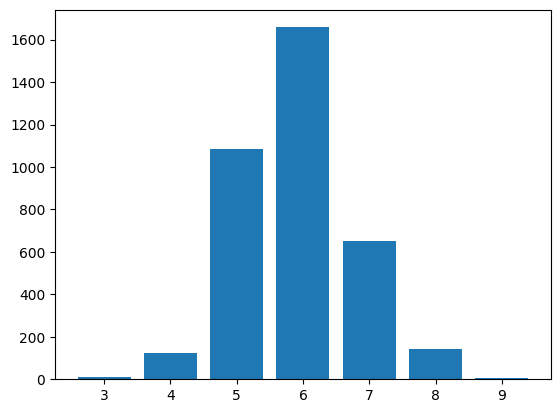

In [7]:
counter = Counter(y_train)
plt.bar(counter.keys(), counter.values())
plt.show()

# 2. ADASYN e Undersampling

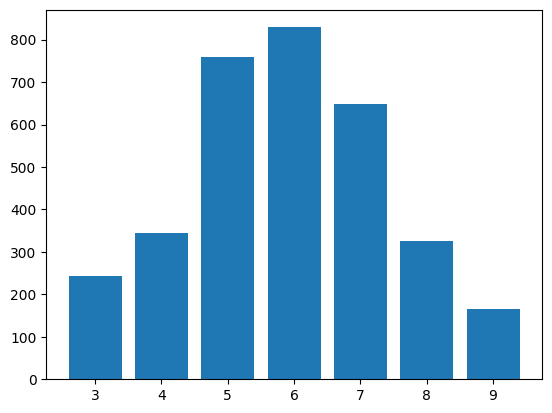

In [8]:
wg = y_train.value_counts()
for i in range(0, len(wg)):
    if wg[i+3] < 6:
        wg[i+3] = 6

strategy1_w = {3:wg[3], 4:wg[4], 5:wg[5], 6:wg[6], 7:wg[7], 8:wg[8], 9:wg[9]}
fix = RandomOverSampler(sampling_strategy=strategy1_w)
wg[8] = round(0.2*wg[6])
wg[4] = round(0.2*wg[6])
wg[9] = round(0.1*wg[6])
wg[3] = round(0.15*wg[6])

strategy2_w = {3:wg[3], 4:wg[4], 8:wg[8], 9:wg[9]}
over = ADASYN(sampling_strategy=strategy2_w)
wg[5] = round(0.7*wg[5])
wg[6] = round(0.5*wg[6])

strategy3_w = {5:wg[5], 6:wg[6]}
under = RandomUnderSampler(sampling_strategy=strategy3_w)
steps = [('f', fix), ('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x_train, y_train = pipeline.fit_resample(x_train, y_train)
counter = Counter(y_train)
plt.bar(counter.keys(), counter.values())
plt.show()

In [9]:
n_classes = pd.get_dummies(y).shape[1]
n_classes

7

# 3. Implementação da RNA

## 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [10]:
# Import packages
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, accuracy_score, recall_score, f1_score
from bayes_opt import BayesianOptimization
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from scikeras.wrappers import KerasClassifier
from sklearn import metrics
import math

pd.set_option("display.max_columns", None)

2022-11-27 21:48:34.497842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 21:48:35.026645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 21:48:35.026676: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-27 21:48:35.086083: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 21:48:36.533643: W tensorflow/stream_executor/platform/de

In [11]:
# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)


In [12]:
score_acc = make_scorer(accuracy_score)

In [13]:
def optmize_cnn(dropout_rate, normalization, neurons,optimizer,
                learning_rate, layers1, layers2, neurons1, neurons2, dropout):


    classificador = Sequential()

    classificador.add(Dense(units = neurons, activation='relu', input_dim = 11))
    
    if normalization > 0.5:
        classificador.add(BatchNormalization())

    for i in range(layers1):
        classificador.add(Dense(neurons1, activation='relu'))
        
    if dropout > 0.5:
        classificador.add(Dropout(dropout_rate, seed=123))

    for i in range(layers2):
        classificador.add(Dense(neurons2, activation='relu'))


    classificador.add(Dense(n_classes, activation="softmax"))

    classificador.compile(loss='categorical_crossentropy', 
                    optimizer=optimizer(learning_rate=learning_rate), metrics=['accuracy'])

    return classificador

In [14]:
def evaluate_network(dropout, normalization, learning_rate, neurons,optimizer, epochs, 
                    batch_size, layer1, layer2, neurons1, neurons2, dropout_rate):
    
    neurons = round(neurons)
    neurons1 = round(neurons1)
    neurons2 = round(neurons2)
    optimizer = round(optimizer)
    epochs = round(epochs)
    batch_size = round(batch_size)
    layer1 = round(layer1)
    layer2 = round(layer2)


    optimizer_array = [Adam, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl, SGD]
    optimizer_val = optimizer_array[optimizer]

    model = optmize_cnn(dropout_rate, normalization, neurons,optimizer_val,
                learning_rate, layer1, layer2, neurons1, neurons2, dropout)
    
    # Train on the bootstrap sample
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    score = []
    
    for train_index, test_index in kf.split(x_train):
        # print("TRAIN:", train_index, "TEST:", test_index)
        xtr, xte = x_train[train_index], x_train[test_index]
        ytr, yte = y_train[train_index], y_train[test_index]

        ytr = pd.get_dummies(ytr)
        yte = pd.get_dummies(yte)

        model.fit(xtr, ytr, epochs=epochs, batch_size=batch_size, verbose=2)

        y_pred = model.predict(xte)
        y_pred = (np.asarray(y_pred)).round()
        y_pred = y_pred.astype(int)
        yte = np.array(yte)

        # roc = roc_auc_score(yte, model.predict_proba(xte), multi_class='ovr')
        # acc = accuracy_score(yte, y_pred)
        f1 = f1_score(yte, y_pred, average='macro')
        score.append(f1)

    score = sum(score)/len(score)

    
    return score

In [15]:
pbounds = {'dropout': (0.0, 0.3),
            'normalization':(0, 1),
            'learning_rate': (0.0, 0.1),
            'neurons': (4, 64),
            'optimizer': (0, 7),
            'epochs' : (50, 300),
            'batch_size': (50, 600),
            'layer1': (1,3),
            'layer2': (1,3),
            'neurons1': (4, 64),
            'neurons2': (4, 64),
            'dropout_rate': (0,0.3)
            }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

optimizer.maximize(init_points=50, n_iter=30,)

In [15]:
# params_nn_ = {'batch_size':371.8,  'dropout':0.1102, 'dropout_rate':0.1927, 'epochs':273.3, 'layer1':2.397, 'layer2':2.7, 'learning_rate':0.0159, 'neurons':55.36, 'neurons1':33.73, 'neurons2':21.38,
#                 'normalization':0.01712,  'optimizer':4.783 }
params_nn_ = optimizer.max['params']
learning_rate = params_nn_['learning_rate']
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = [Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl, Adam]
params_nn_['optimizer'] = optimizerL[round(params_nn_['optimizer'])]
params_nn_['layer1'] = round(params_nn_['layer1'])
params_nn_['layer2'] = round(params_nn_['layer2'])
params_nn_['neurons1'] = round(params_nn_['neurons1'])
params_nn_['neurons2'] = round(params_nn_['neurons2'])
params_nn_

{'batch_size': 372,
 'dropout': 0.1102,
 'dropout_rate': 0.1927,
 'epochs': 273,
 'layer1': 2,
 'layer2': 3,
 'learning_rate': 0.0159,
 'neurons': 55,
 'neurons1': 34,
 'neurons2': 21,
 'normalization': 0.01712,
 'optimizer': keras.optimizers.optimizer_v2.adamax.Adamax}

In [16]:
model = optmize_cnn(params_nn_['dropout_rate'], params_nn_['normalization'], params_nn_['neurons'],params_nn_['optimizer'],
                    params_nn_['learning_rate'], params_nn_['layer1'], params_nn_['layer2'], params_nn_['neurons1'],
                    params_nn_['neurons2'], params_nn_['dropout'])


nn = KerasClassifier(model=model, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'], verbose=0)

y_train = pd.get_dummies(y_train)
nn.fit(x_train, y_train, verbose=1)

2022-11-27 21:48:45.965702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-27 21:48:45.966067: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-27 21:48:45.966567: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gbriel-pc): /proc/driver/nvidia/version does not exist
2022-11-27 21:48:45.968535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/273
9/9 [==============================] - 2s 5ms/step - loss: 1.8143 - accuracy: 0.2740
Epoch 2/273
9/9 [==============================] - 0s 5ms/step - loss: 1.5773 - accuracy: 0.3711
Epoch 3/273
9/9 [==============================] - 0s 3ms/step - loss: 1.4256 - accuracy: 0.4040
Epoch 4/273
9/9 [==============================] - 0s 3ms/step - loss: 1.2985 - accuracy: 0.4537
Epoch 5/273
9/9 [==============================] - 0s 3ms/step - loss: 1.2199 - accuracy: 0.4824
Epoch 6/273
9/9 [==============================] - 0s 3ms/step - loss: 1.1614 - accuracy: 0.5029
Epoch 7/273
9/9 [==============================] - 0s 3ms/step - loss: 1.1079 - accuracy: 0.5143
Epoch 8/273
9/9 [==============================] - 0s 3ms/step - loss: 1.0602 - accuracy: 0.5276
Epoch 9/273
9/9 [==============================] - 0s 3ms/step - loss: 1.0273 - accuracy: 0.5475
Epoch 10/273
9/9 [==============================] - 0s 3ms/step - loss: 0.9975 - accuracy: 0.5496
Epoch 11/273
9/9 [===========

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7fd38aa67c40>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=372
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=273
	class_weight=None
)

In [17]:
y_test = pd.get_dummies(y_test)
nn.score(x_test, y_test)

0.5485714285714286

In [18]:
y_pred = nn.predict(x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = [3,4,5,6,7,8,9]


In [19]:
y_test = y_test.idxmax(axis=1)
y_pred = y_pred.idxmax(axis=1)

In [20]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[  1,   1,   3,   0,   2,   0,   0],
       [  0,  15,  14,   9,   2,   0,   0],
       [  8,  14, 233,  90,  23,   5,   0],
       [  6,  18, 122, 265, 114,  14,   1],
       [  0,   2,  18,  49, 142,  20,   0],
       [  0,   0,   2,   7,   8,  16,   0],
       [  0,   0,   0,   0,   0,   1,   0]])

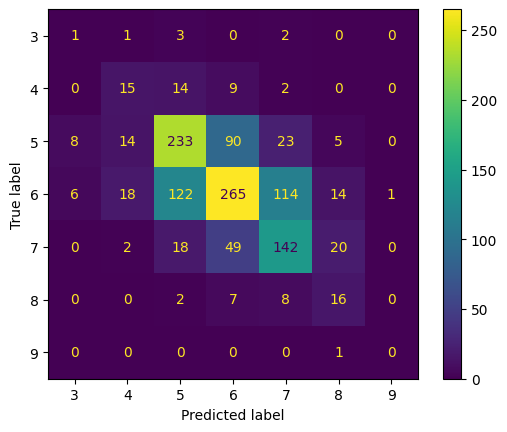

In [21]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [3,4,5,6,7,8,9])
cm_display.plot()
plt.savefig("Crna_w.png")

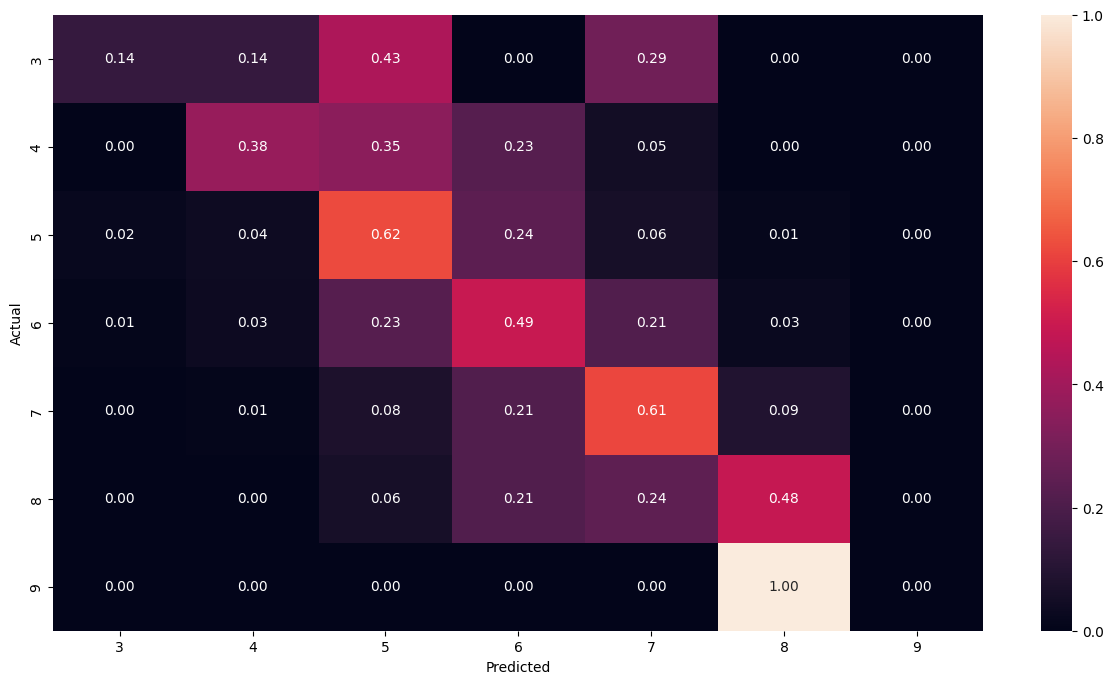

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)